In [ ]:
# Check Colab's OS and architecture to get the correct download link
!cat /etc/os-release | grep "VERSION_ID"
!echo "Machine's architecture: `uname -i`"

# Download and install Nsight Systems (example for Ubuntu 22.04)
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
!apt update
!apt install ./nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
!apt --fix-broken install


VERSION_ID="22.04"
Machine's architecture: x86_64
--2025-07-30 03:05:29--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.40.40.50, 23.40.40.11, 23.40.40.43, ...
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.40.40.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317705436 (303M) [application/x-deb]
Saving to: ‘nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb’

nsight-systems-2023 100%[===================>] 302.99M  2.31MB/s    in 1m 57s  

2025-07-30 03:07:28 (2.59 MB/s) - ‘nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb’ saved [317705436/317705436]

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-

STEP 1: EMBED INPUT IDS AND PROJECT INTO Q, K, V

In [ ]:
# STEP 1: EMBED INPUT IDS AND PROJECT INTO Q, K, V

import torch
from torch import nn

# --- config ---
device = 'cuda'
dtype  = torch.float32          # set to torch.float16 for mixed precision
B, S   = 100, 128                # batch, seq_len
H, D   = 8, 64                   # num heads, head dim
E      = H * D                   # model dim
Vocab  = 30522                   # fake vocab size

torch.manual_seed(0)

# --- inputs: token ids ---
input_ids = torch.randint(0, Vocab, (B, S), device=device)

# --- layers ---
embed    = nn.Embedding(Vocab, E).to(device=device, dtype=dtype)
qkv_proj = nn.Linear(E, 3 * E, bias=False).to(device=device, dtype=dtype)

# --- forward: [B,S] -> [B,S,E] -> [B,S,3E] ---
x   = embed(input_ids)                 # [B, S, E]
qkv = qkv_proj(x)                      # [B, S, 3E]
q, k, v = qkv.chunk(3, dim=-1)         # each [B, S, E]

# --- reshape to [B,H,S,D] (attention-friendly) ---
# go from [B,S,E] -> [B,S,H,D] -> [B,H,S,D]
q = q.view(B, S, H, D).permute(0, 2, 1, 3).contiguous()
k = k.view(B, S, H, D).permute(0, 2, 1, 3).contiguous()
v = v.view(B, S, H, D).permute(0, 2, 1, 3).contiguous()

print("input_ids:", input_ids.shape)
print("x (emb):  ", x.shape)
print("q,k,v:    ", q.shape, k.shape, v.shape)   # all [B, H, S, D]


input_ids: torch.Size([100, 128])
x (emb):   torch.Size([100, 128, 512])
q,k,v:     torch.Size([100, 8, 128, 64]) torch.Size([100, 8, 128, 64]) torch.Size([100, 8, 128, 64])


STEP 2: PYTORCH ATTENTION BASELINE CODE

In [ ]:
import torch
import torch.nn as nn

def pytorch_attention(q, k,v, mask=None):
  B, H, S,D = q.shape
  scale=D**-0.5

  attn_scores = torch.matmul(q, k.transpose(-2, -1))*scale
  #if mask is not None:
    #attn_scores = attn_scores.masked_fill(mask[:, None, None, :] == 0, float('-inf'))

  attn_probs = torch.softmax(attn_scores, dim=-1)
  out = torch.matmul(attn_probs,v)
  return out

out_pt = pytorch_attention(q, k,v)
print("Output shape (PyTorch)", out_pt.shape)


#Pseudocode:
#1.Compute attention scores, matmul(Q, K^T) shape = [B, H, S, S]
#2. Scale scores by sqrt (D)
#3. If mask is given
   #Expand mask to shape [B,1,1,S]
   #Set scores at masked position to -infinity
#4. Apply softmax along last dimension (keys) shape = [B,H,S,S]
#5. Compute weighted sum [ B,H,S,D]
#6. Return output


Output shape (PyTorch) torch.Size([100, 8, 128, 64])


STEP 3: FLASH ATTENTION 2 FORWARD PASS

In [ ]:
"""
Pseudocode:

1. Initialize output O = zeros_like(Q) shape = [B,H,S,D]
2. For each query block j = 0 to S step BLOCK_M:
   2.1 Load Q_block = Q[..., j : j+BLOCK_M, :] shape = [B,H,BLOCK_M, D]
   2.2 Initialize:
        - m_j = -infinity (max logits per row)
        - l_j = 0 (exp sum per row)
        - acc_j = (accumulated output for Q_block)
   2.3 For each block i=0 to S step BLOCK_N:
       -load K_block = K[..., i: i+BLOCK_N, :] shape = [B,H, BLOCK_N, D]
       -load V_block = V[..., i: I+N, :] shape = [B,H, BLOCK_N, D]
       -compute scores = Q_block @ K_block^T/sqrt(D) shape = [B,H, BLOCK_M, BLOCK_N]
       -(OPTIONAL: apply causal mask if  i> j)
       - m_ij = max(scores, dim =-1)
       - p_ij = exp(scores - m_ij)
       - l_ij = sum(p_ij, dim=-1)
       - acc_ij = p_ij @ V_block shape = [B,H, BLOCK_M, D]
       - m_j , l_j, acc_j = online_softmax_update(m_j, l_j, acc_j, m_ij, l_ij, acc_ij)
  2.4 Normalize:
      O[..., j:j+BLOCK_M, :] = acc_j / l_j.unsqueeze(-1)
3. Return O
"""

import torch
import triton
import triton.language as tl

# ----------------------------
# 1. Triton kernel (FlashAttention 2 forward)
# ----------------------------
@triton.jit
def flashattn2_forward(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    stride_qb, stride_qh, stride_qs, stride_qd,
    stride_kb, stride_kh, stride_ks, stride_kd,
    stride_vb, stride_vh, stride_vs, stride_vd,
    stride_ob, stride_oh, stride_os, stride_od,
    B, H, S, D,
    BLOCK_M: tl.constexpr,   # query‐block size
    BLOCK_N: tl.constexpr,   # key/value‐block size
    BLOCK_D: tl.constexpr    # head dimension (must == D)
):
    # Identify this program's (batch, head, query‐block)
    batch_id = tl.program_id(0)
    head_id  = tl.program_id(1)
    start_m  = tl.program_id(2) * BLOCK_M

    # Offsets in Q/K/V
    offs_m = start_m + tl.arange(0, BLOCK_M)    # [BLOCK_M]
    offs_n = tl.arange(0, BLOCK_N)              # [BLOCK_N]
    offs_d = tl.arange(0, BLOCK_D)              # [BLOCK_D]

    # Compute pointers into Q and output
    Q_ptr_block = (
        Q_ptr
        + batch_id * stride_qb
        + head_id  * stride_qh
        + (offs_m[:, None] * stride_qs) # Added parentheses for clarity
        + (offs_d[None, :] * stride_qd) # Added parentheses for clarity
    )
    O_ptr_block = (
        Out_ptr
        + batch_id * stride_ob
        + head_id  * stride_oh
        + (offs_m[:, None] * stride_os) # Added parentheses for clarity
        + (offs_d[None, :] * stride_od) # Added parentheses for clarity
    )

    # Load Q [BLOCK_M, BLOCK_D]
    # Ensure mask covers all elements within the block that are within bounds
    Q = tl.load(Q_ptr_block, mask=(offs_m[:, None] < S) & (offs_d[None, :] < D), other=0.0)o


    # Initialize accumulators & softmax state
    acc = tl.zeros((BLOCK_M, BLOCK_D), dtype=tl.float32)
    m_i = tl.full ((BLOCK_M,), float("-inf"), dtype=tl.float32)
    l_i = tl.zeros((BLOCK_M,), dtype=tl.float32)

    # Scale factor 1/sqrt(D), using BLOCK_D as compile‐time constant
    scale = 1.0 / tl.sqrt(float(BLOCK_D))

    # Loop over key/value blocks
    for start_n in range(0, S, BLOCK_N):
        offs_k = start_n + tl.arange(0, BLOCK_N)

        # ptrs for K and V blocks
        K_ptr_block = (
            K_ptr
            + batch_id * stride_kb
            + head_id  * stride_kh
            + (offs_k[:, None] * stride_ks) # Added parentheses for clarity
            + (offs_d[None, :] * stride_kd) # Added parentheses for clarity
        )
        V_ptr_block = (
            V_ptr
            + batch_id * stride_vb
            + head_id  * stride_vh
            + (offs_k[:, None] * stride_vs) # Added parentheses for clarity
            + (offs_d[None, :] * stride_vd) # Added parentheses for clarity
        )
        # Load K and V blocks, ensure mask covers all elements within bounds
        K = tl.load(K_ptr_block, mask=(offs_k[:, None] < S) & (offs_d[None, :] < D), other=0.0)
        V = tl.load(V_ptr_block, mask=(offs_k[:, None] < S) & (offs_d[None, :] < D), other=0.0)


        # Compute scaled dot‐product Q·Kᵀ
        scores = tl.dot(Q, tl.trans(K)) * scale        # [BLOCK_M, BLOCK_N]

        # Numerically stable softmax prep
        m_ij = tl.max(scores, axis=1)                  # [BLOCK_M]
        scores = scores - m_ij[:, None]

        # Softmax numerator & sum
        p_ij = tl.exp(scores)                          # [BLOCK_M, BLOCK_N]
        l_ij = tl.sum(p_ij, axis=1)                    # [BLOCK_M]
        acc_ij = tl.dot(p_ij, V)                       # [BLOCK_M, BLOCK_D]

        # Online softmax update
        m_i_new = tl.maximum(m_i, m_ij)
        alpha   = tl.exp(m_i   - m_i_new)
        beta    = tl.exp(m_ij  - m_i_new)
        l_i_new = alpha * l_i + beta * l_ij

        acc = acc * alpha[:, None] + acc_ij * beta[:, None]
        m_i = m_i_new
        l_i = l_i_new

    # Final normalization & write‐back
    O = acc / l_i[:, None]
    # Ensure mask covers all elements within the output block that are within bounds
    tl.store(O_ptr_block, O, mask=(offs_m[:, None] < S) & (offs_d[None, :] < D))

In [ ]:
def run_flashattn2_triton(
    q: torch.Tensor, k: torch.Tensor, v: torch.Tensor,
    BLOCK_M: int = 128, BLOCK_N: int = 64
) -> torch.Tensor:
    """
    q,k,v: [B,H,S,D], cuda float32, contiguous
    Returns out: [B,H,S,D]
    """
    assert q.is_cuda and q.dtype == torch.float32
    B, H, S, D = q.shape
    out = torch.empty_like(q)

    # extract strides
    def strides(x):
        return x.stride(0), x.stride(1), x.stride(2), x.stride(3)
    sqb, sqh, sqs, sqd = strides(q)
    skb, skh, sks, skd = strides(k)
    svb, svh, svs, svd = strides(v)
    sob, soh, sos, sod = strides(out)

    # 3D grid: (batch, head, num_query_blocks)
    grid = (B, H, triton.cdiv(S, BLOCK_M))

    # launch
    flashattn2_forward[grid](
        q, k, v, out,
        sqb, sqh, sqs, sqd,
        skb, skh, sks, skd,
        svb, svh, svs, svd,
        sob, soh, sos, sod,
        B, H, S, D,
        BLOCK_M=BLOCK_M,
        BLOCK_N=BLOCK_N,
        BLOCK_D=D,    # must equal head‐dim
    )
    return out

STEP 5: CHECK CORRECTNESS

In [ ]:
import torch

B,H,S,D = 100,8,128,64

q = torch.randn(B,H,S,D, device='cuda', dtype = torch.float32)
k = torch.randn(B,H,S,D, device='cuda', dtype = torch.float32)
v = torch.randn(B, H, S, D, device='cuda', dtype=torch.float32)
print("Q shape:", q.shape)

out_pt = pytorch_attention(q, k, v)
out_triton = run_flashattn2_triton(q, k, v)

print("Output shape OK:", out_pt.shape == out_triton.shape)

print("Numerical match:", torch.allclose(out_pt, out_triton, atol=5e-2, rtol=1e-2))
print("Max abs error:", (out_pt - out_triton).abs().max().item())

print("out_pt[0, 0, 0, :5]:", out_pt[0, 0, 0, :5])
print("out_triton[0, 0, 0, :5]:", out_triton[0, 0, 0, :5])
print("diff:", (out_pt - out_triton)[0, 0, 0, :5])

Q shape: torch.Size([100, 8, 128, 64])
Output shape OK: True
Numerical match: True
Max abs error: 0.0035746097564697266
out_pt[0, 0, 0, :5]: tensor([ 0.0296, -0.2589,  0.0683,  0.1036, -0.0654], device='cuda:0')
out_triton[0, 0, 0, :5]: tensor([ 0.0297, -0.2586,  0.0685,  0.1035, -0.0655], device='cuda:0')
diff: tensor([-1.0759e-05, -2.4363e-04, -1.3004e-04,  5.5224e-05,  1.3515e-05],
       device='cuda:0')


STEP 6: BENCHMARKING PERFORMANCE

In [ ]:
import torch
import torch.cuda.nvtx as nvtx # Import NVTX
import matplotlib.pyplot as plt

def benchmark_attention(B=100, H=8, D=64, seqs=[64, 128, 256, 512, 1024, 2048]):
    device = 'cuda'
    results = []
    for S in seqs:
        q = torch.randn(B, H, S, D, device=device)
        k = torch.randn_like(q)
        v = torch.randn_like(q)

        # Warm-up
        _ = pytorch_attention(q, k, v); torch.cuda.synchronize()
        _ = run_flashattn2_triton(q, k, v, BLOCK_M=64, BLOCK_N=64); torch.cuda.synchronize()

        # Time PyTorch with NVTX range
        nvtx.range_push(f"PyTorch S={S}")
        start, end = torch.cuda.Event(True), torch.cuda.Event(True)
        start.record(); _ = pytorch_attention(q, k, v); end.record()
        torch.cuda.synchronize()
        t_pt = start.elapsed_time(end)
        nvtx.range_pop()

        # Time Triton with NVTX range
        nvtx.range_push(f"Triton S={S}")
        start.record(); _ = run_flashattn2_triton(q, k, v, BLOCK_M=64, BLOCK_N=64); end.record()
        torch.cuda.synchronize()
        t_tr = start.elapsed_time(end)
        nvtx.range_pop()

        speedup = t_pt / t_tr
        print(f"S={S:4d} | PyTorch: {t_pt:6.2f}ms | Triton: {t_tr:6.2f}ms | Speedup: {speedup:4.1f}×")
        results.append((S, t_pt, t_tr, speedup))
    return results

STEP 7- PLOTTING RESULTS

S=  64 | PyTorch:   0.41ms | Triton:   0.27ms | Speedup:  1.6×
S= 128 | PyTorch:   0.65ms | Triton:   0.32ms | Speedup:  2.0×
S= 256 | PyTorch:   2.18ms | Triton:   0.73ms | Speedup:  3.0×
S= 512 | PyTorch:   8.30ms | Triton:   2.34ms | Speedup:  3.6×
S=1024 | PyTorch:  32.78ms | Triton:   8.15ms | Speedup:  4.0×
S=2048 | PyTorch: 114.96ms | Triton:  24.18ms | Speedup:  4.8×


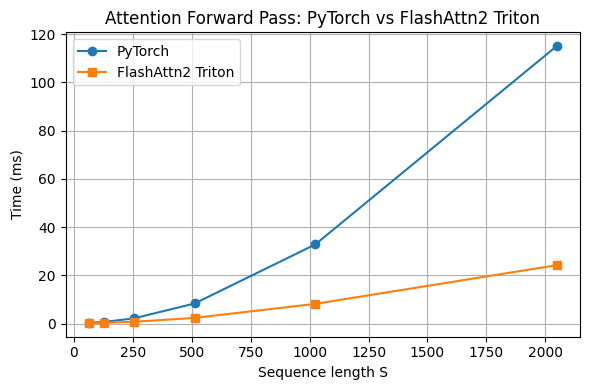

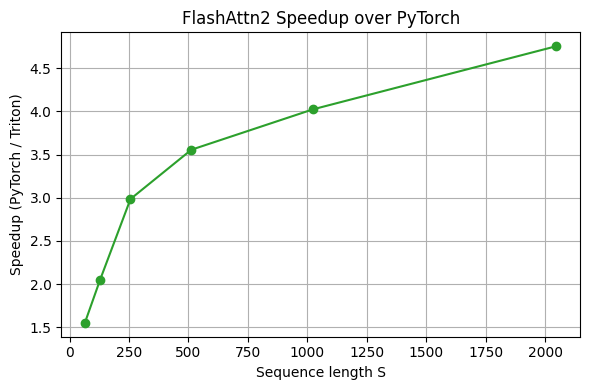

In [ ]:
bench = benchmark_attention()

# Unpack for plotting
Ss, t_pts, t_trs, speedups = zip(*bench)

# Plot absolute times
plt.figure(figsize=(6,4))
plt.plot(Ss, t_pts, marker='o', label='PyTorch')
plt.plot(Ss, t_trs, marker='s', label='FlashAttn2 Triton')
plt.xlabel('Sequence length S')
plt.ylabel('Time (ms)')
plt.title('Attention Forward Pass: PyTorch vs FlashAttn2 Triton')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot speedup
plt.figure(figsize=(6,4))
plt.plot(Ss, speedups, marker='o', color='tab:green')
plt.xlabel('Sequence length S')
plt.ylabel('Speedup (PyTorch / Triton)')
plt.title('FlashAttn2 Speedup over PyTorch')
plt.grid(True)
plt.tight_layout()
plt.show()

### Create a python script from notebook cell

In [ ]:
%%writefile flash_attention.py

import torch
import torch.nn as nn
import triton
import triton.language as tl
import torch.cuda.nvtx as nvtx

# =================================================================
# STEP 3: PYTORCH ATTENTION BASELINE CODE
# =================================================================
def pytorch_attention(q, k, v, mask=None):
  B, H, S, D = q.shape
  scale = D**-0.5

  attn_scores = torch.matmul(q, k.transpose(-2, -1)) * scale
  if mask is not None:
    attn_scores = attn_scores.masked_fill(mask[:, None, None, :] == 0, float('-inf'))

  attn_probs = torch.softmax(attn_scores, dim=-1)
  out = torch.matmul(attn_probs, v)
  return out

# =================================================================
# STEP 4: FLASH ATTENTION 2 FORWARD PASS (TRITON KERNEL)
# =================================================================
@triton.jit
def flashattn2_forward(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    stride_qb, stride_qh, stride_qs, stride_qd,
    stride_kb, stride_kh, stride_ks, stride_kd,
    stride_vb, stride_vh, stride_vs, stride_vd,
    stride_ob, stride_oh, stride_os, stride_od,
    B, H, S, D,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_D: tl.constexpr
):
    batch_id = tl.program_id(0)
    head_id  = tl.program_id(1)
    start_m  = tl.program_id(2) * BLOCK_M

    offs_m = start_m + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_d = tl.arange(0, BLOCK_D)

    Q_ptr_block = (Q_ptr + batch_id * stride_qb + head_id * stride_qh + offs_m[:, None] * stride_qs + offs_d[None, :] * stride_qd)
    O_ptr_block = (Out_ptr + batch_id * stride_ob + head_id * stride_oh + offs_m[:, None] * stride_os + offs_d[None, :] * stride_od)
    Q = tl.load(Q_ptr_block, mask=offs_m[:, None] < S, other=0.0)

    acc = tl.zeros((BLOCK_M, BLOCK_D), dtype=tl.float32)
    m_i = tl.full((BLOCK_M,), float("-inf"), dtype=tl.float32)
    l_i = tl.zeros((BLOCK_M,), dtype=tl.float32)
    scale = 1.0 / tl.sqrt(float(BLOCK_D))

    for start_n in range(0, S, BLOCK_N):
        offs_k = start_n + tl.arange(0, BLOCK_N)
        K_ptr_block = (K_ptr + batch_id * stride_kb + head_id * stride_kh + offs_k[:, None] * stride_ks + offs_d[None, :] * stride_kd)
        V_ptr_block = (V_ptr + batch_id * stride_vb + head_id * stride_vh + offs_k[:, None] * stride_vs + offs_d[None, :] * stride_vd)
        K = tl.load(K_ptr_block, mask=offs_k[:, None] < S, other=0.0)
        V = tl.load(V_ptr_block, mask=offs_k[:, None] < S, other=0.0)

        scores = tl.dot(Q, tl.trans(K)) * scale
        m_ij = tl.max(scores, axis=1)
        scores = scores - m_ij[:, None]
        p_ij = tl.exp(scores)
        l_ij = tl.sum(p_ij, axis=1)
        acc_ij = tl.dot(p_ij, V)
        m_i_new = tl.maximum(m_i, m_ij)
        alpha   = tl.exp(m_i - m_i_new)
        beta    = tl.exp(m_ij - m_i_new)
        l_i_new = alpha * l_i + beta * l_ij
        acc = acc * alpha[:, None] + acc_ij * beta[:, None]
        m_i = m_i_new
        l_i = l_i_new

    O = acc / l_i[:, None]
    tl.store(O_ptr_block, O, mask=offs_m[:, None] < S)

def run_flashattn2_triton(q, k, v, BLOCK_M=128, BLOCK_N=64):
    B, H, S, D = q.shape
    out = torch.empty_like(q)
    strides = lambda x: (x.stride(0), x.stride(1), x.stride(2), x.stride(3))
    grid = (B, H, triton.cdiv(S, BLOCK_M))
    flashattn2_forward[grid](
        q, k, v, out,
        *strides(q), *strides(k), *strides(v), *strides(out),
        B, H, S, D,
        BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N, BLOCK_D=D
    )
    return out

# =================================================================
# STEP 6: BENCHMARKING PERFORMANCE (MODIFIED FOR PROFILING)
# =================================================================
def benchmark_attention(B=100, H=8, D=64, seqs=[1024]):
    device = 'cuda'
    for S in seqs:
        print(f"Profiling S={S:4d}...")
        q = torch.randn(B, H, S, D, device=device)
        k = torch.randn_like(q)
        v = torch.randn_like(q)

        # PyTorch with NVTX range
        nvtx.range_push(f"PyTorch S={S}")
        _ = pytorch_attention(q, k, v)
        torch.cuda.synchronize()
        nvtx.range_pop()

        # Triton with NVTX range
        nvtx.range_push(f"Triton S={S}")
        _ = run_flashattn2_triton(q, k, v, BLOCK_M=64, BLOCK_N=64)
        torch.cuda.synchronize()
        nvtx.range_pop()

# =================================================================
# MAIN EXECUTION
# =================================================================
if __name__ == "__main__":
    # First, ensure you have installed Triton
    # pip install triton
    print("Starting benchmark for profiling...")
    benchmark_attention()
    print("Profiling benchmark finished.")

Writing flash_attention.py


In [ ]:
!nsys profile --trace=cuda,nvtx -o flash_attention_report python flash_attention.py

Starting benchmark for profiling...
Profiling S=  64...
Profiling S= 128...
Profiling S= 256...
Profiling S= 512...
Profiling S=1024...
Profiling S=2048...
Profiling benchmark finished.
Generating '/tmp/nsys-report-7ac5.qdstrm'
[1/1] [========================100%] flash_attention_report.nsys-rep
Generated:
    /content/flash_attention_report.nsys-rep


In [ ]:
# This command tells ncu to find the NVTX range named "Triton S=1024"
# and profile the kernels inside it. We save the report to a file.

!ncu --nvtx --nvtx-include "Triton S=1024/" -o triton_kernel_report.ncu-rep python flash_attention.py

Starting benchmark for profiling...
Profiling S=  64...
==PROF== Connected to process 6219 (/usr/bin/python3.11)
Profiling S= 128...
Profiling S= 256...
Profiling S= 512...
Profiling S=1024...
==PROF== Profiling "flashattn2_forward" - 0: 0%
==WARNING== Backing up device memory in system memory. Kernel replay might be slow. Consider using "--replay-mode application" to avoid memory save-and-restore.
....50%....100% - 10 passes
Profiling S=2048...
Profiling benchmark finished.
==PROF== Disconnected from process 6219
==PROF== Report: /content/triton_kernel_report.ncu-rep
